1. Lectura del archivo

In [55]:
import pandas as pd

# Path 
file_path = r"C:\Users\param\OneDrive\Escritorio\Programacion\Soy Henry\Proyecto-sentimientos\DATASET\df_fast_food_yelp.csv"

# Lectura
df_fast_food = pd.read_csv(file_path, encoding="utf-8-sig")

2. Tratamiento de las variables

2.1 Obtener los años de antiguedad en Yelp.

In [57]:
#Transformamos a un entero la antiguedad de estar en Yelp
import pandas as pd
from datetime import datetime

# Formato de la columna
df_fast_food['yelping_since'] = pd.to_datetime(df_fast_food['yelping_since'], errors='coerce')

# Hoy
today = pd.to_datetime(datetime.today().date())

# Difference in days
df_fast_food['yelping_dias'] = (today - df_fast_food['yelping_since']).dt.days

# En años
df_fast_food['yelping_years'] = df_fast_food['yelping_dias'] // 365

2.2 Eliminamos las columnas que no son necesarias. Es importante recalcar que las variables sobre los usuarios fueron usados para segmentar el tipo de influencer. Ya que están creadas estas variables, se pueden borrar.

In [58]:
# Lista de columnas que eliminamos para el modelo de ML... Gran parte fueron para crear el clustering de los influencers
cols_to_drop = ['review_id', 'user_id', 'business_id','text',
                 'date','is_open','attributes',
                 'useful_x_escalado',
       'funny_x_escalado', 'cool_x_escalado', 'review_count_x_escalado',
       'useful_y_escalado', 'funny_y_escalado', 'cool_y_escalado',
       'fans_escalado', 'compliment_hot_escalado', 'compliment_more_escalado',
       'compliment_profile_escalado', 'compliment_cute_escalado',
       'compliment_list_escalado', 'compliment_note_escalado',
       'compliment_plain_escalado', 'compliment_cool_escalado',
       'compliment_funny_escalado', 'compliment_writer_escalado',
       'compliment_photos_escalado', 'review_count_y_escalado',
       "vader_neg_google", 'vader_neu_google', 'vader_pos_google',
       'vader_compound_google',"yelping_dias","yelping_since","elite","name"]


df_fast_food.drop(columns=cols_to_drop, inplace=True)


In [59]:
# Mapeo de valores para volverl positivo, neutro y negativo a enteros.
mapa = {'Positive': 1, 'Neutral': 0, 'Negative': -1}

# Convertir los valores
df_fast_food['sentimiento_num'] = df_fast_food['vader_sentiment_google'].map(mapa)

#Borrar la antigua
df_fast_food = df_fast_food.drop("vader_sentiment_google", axis=1)

3. Enfocarnos en SALEM y FAST FOOD

In [62]:
df_fast_food[
    (df_fast_food["County"] == "SALEM") &
    (df_fast_food["category"] == "FastFood")
]


#Eliminamos las columnas de las categorias
cols_to_drop = ["County","category","yelping_years"]


df_fast_food.drop(columns=cols_to_drop, inplace=True)

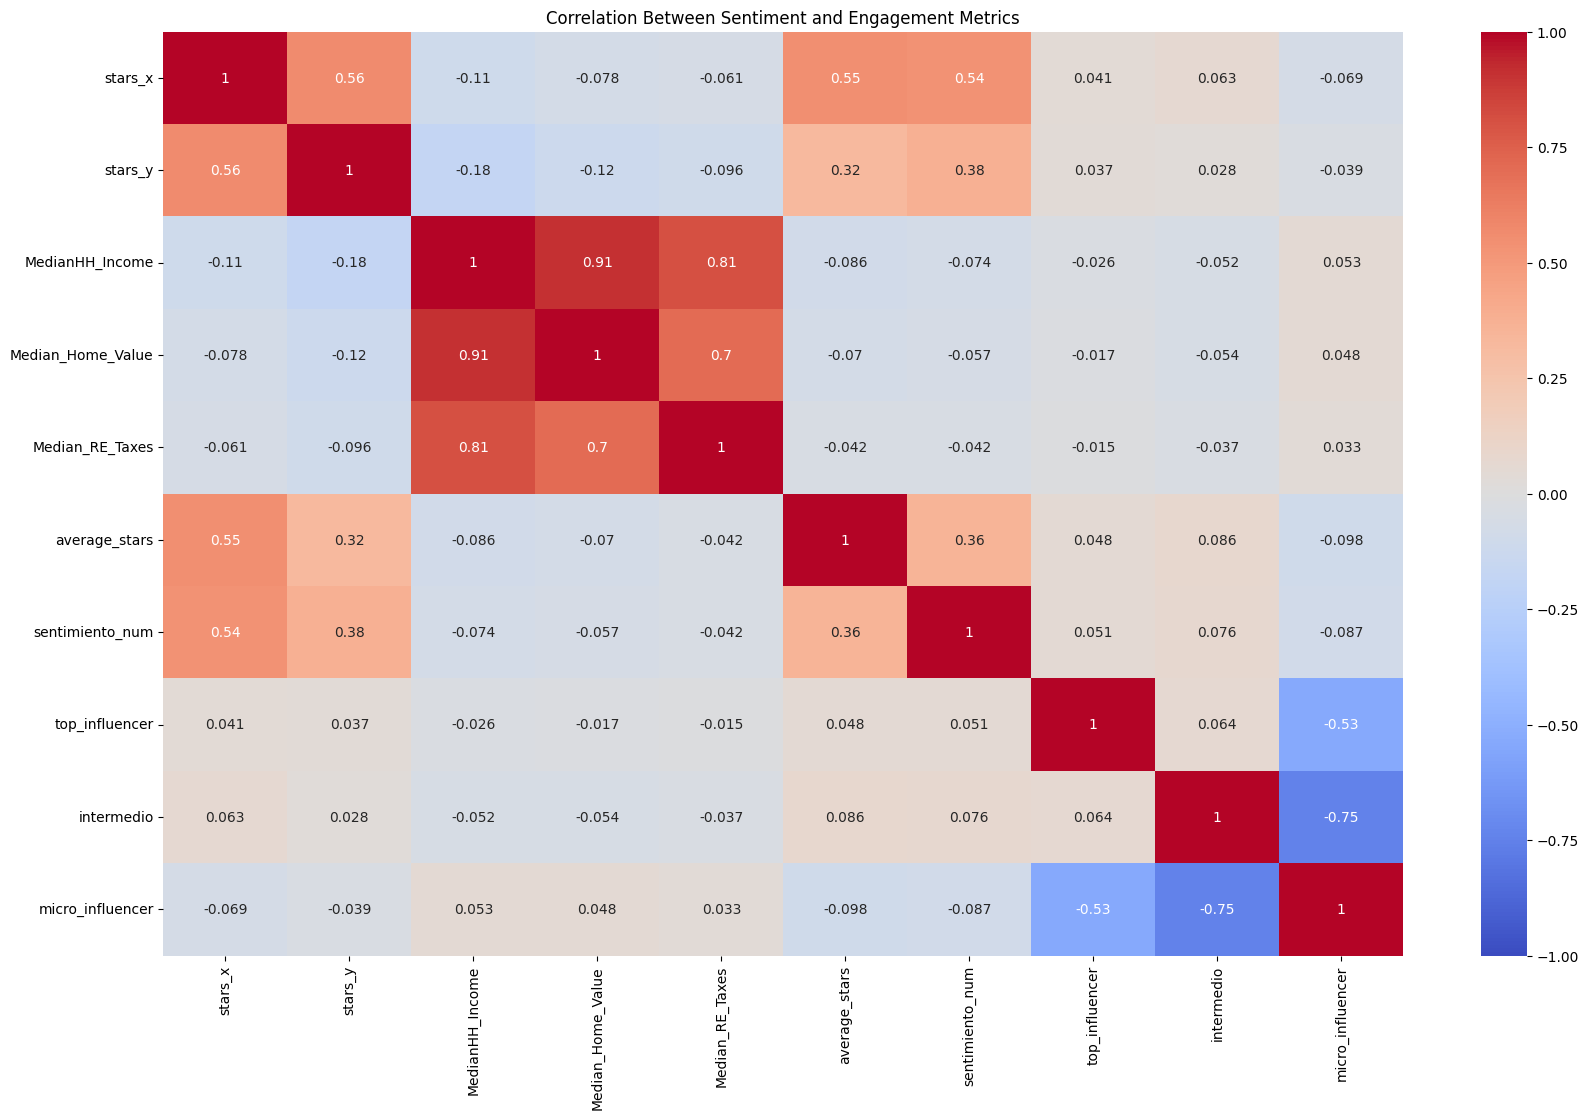

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de correlación
corr_matrix = df_fast_food[['stars_x', 'stars_y', 'MedianHH_Income',
       'Median_Home_Value', 'Median_RE_Taxes',
     'average_stars', 'sentimiento_num', 'top_influencer',
       'intermedio', 'micro_influencer']].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(20, 12))

# Crear el heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0
)

plt.title("Correlation Between Sentiment and Engagement Metrics")
plt.show()


4. Creamos el modelo de ML- Primero con Regresión Logistica

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Separar los datos
X = df_fast_food.drop(columns=['sentimiento_num'])
y = df_fast_food['sentimiento_num']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression logistica- notar que se balancearon las clases debido a que el modelo solo pronosticaba 1
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,class_weight="balanced")
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)


              precision    recall  f1-score   support

          -1       0.20      0.36      0.26      1517
           0       0.03      0.04      0.03       232
           1       0.85      0.71      0.78      8628

    accuracy                           0.65     10377
   macro avg       0.36      0.37      0.36     10377
weighted avg       0.74      0.65      0.68     10377



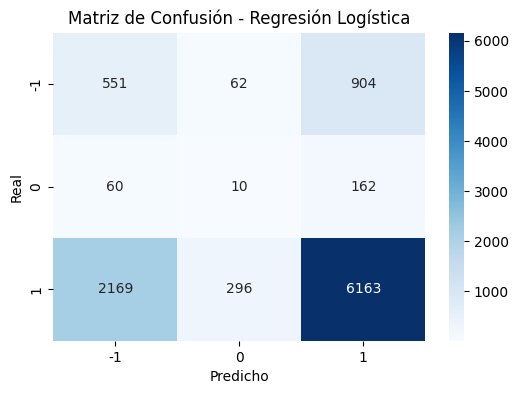

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

# Métricas numéricas
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])

# Visualización
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()


A pesar de usar la opción de "class_weight"=balanced, aun hay muchos problemas para predecir el 0 y -1. Pasemos a dos opciones: -1 y 1 (es decir, no hay reseñas neutras). Es una prueba para observar si mejora el resultado.

In [34]:
# Unificamos las clases: todo lo que sea 0 pasa a -1
df_fast_food_prueba=df_fast_food
df_fast_food_prueba['sentimiento_bin'] = df_fast_food['sentimiento_num'].replace({0: -1})
df_fast_food_prueba.drop('sentimiento_num', axis=1, inplace=True)

In [35]:
# Misma regresión logística pero con solo -1 y 1.
X = df_fast_food_prueba.drop(columns=['sentimiento_bin'])
y = df_fast_food['sentimiento_bin']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression logistica- notar que se balancearon las clases
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,class_weight="balanced")
log_reg.fit(X_train, y_train)

# Predicciones
y_pred = log_reg.predict(X_test)


              precision    recall  f1-score   support

          -1       0.48      0.79      0.59      1749
           1       0.95      0.82      0.88      8628

    accuracy                           0.82     10377
   macro avg       0.71      0.81      0.74     10377
weighted avg       0.87      0.82      0.83     10377



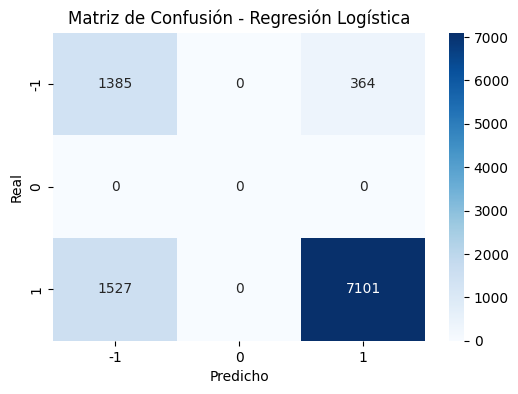

In [36]:
# Métricas numéricas
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])

# Visualización
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

El modelo mejoró bastante al unificar -1 y 0 en una clase. Aún así es muy generoso marcando negativos para predecir y explica la precisión baja de 48% en los negativos, mientras que es del 95% para los positivos.  

In [37]:
# Obtener nombres de las variables
feature_nombres = X.columns

# Coeficientes del modelo
coefs = log_reg.coef_[0]  # [0] porque es binario (solo una fila)

# Crear un DataFrame ordenado por importancia
importancia = pd.DataFrame({
    'Variable': feature_nombres,
    'Peso (coeficiente)': coefs
}).sort_values(by='Peso (coeficiente)', ascending=False)

# Mostrar

pd.options.display.float_format = '{:.8f}'.format
print(importancia)


            Variable  Peso (coeficiente)
0            stars_x          0.41388369
1            stars_y          0.17259064
5      average_stars          0.14980547
7         intermedio          0.01333712
6     top_influencer          0.00538983
2    MedianHH_Income          0.00000807
3  Median_Home_Value          0.00000088
4    Median_RE_Taxes         -0.00045110
8   micro_influencer         -0.01529447


4.1 Observemos cuáles son las variables mas importantes de esta regresión.

5.1 Creamos Árbol Decisión

In [63]:
# Separar los datos
X = df_fast_food.drop(columns=['sentimiento_num'])
y = df_fast_food['sentimiento_num']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # Puedes ajustar max_depth
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [66]:
#Validamos el modelo
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8552568179628024
              precision    recall  f1-score   support

          -1       0.55      0.60      0.57      1517
           0       0.00      0.00      0.00       232
           1       0.91      0.92      0.92      8628

    accuracy                           0.86     10377
   macro avg       0.49      0.51      0.50     10377
weighted avg       0.84      0.86      0.85     10377



c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [67]:
# Importancias de cada variable
importancias = clf.feature_importances_

# Crear un DataFrame ordenado

feature_importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print(feature_importancia)

            Variable  Importancia
0            stars_x   0.94629098
1            stars_y   0.03410620
5      average_stars   0.01960282
2    MedianHH_Income   0.00000000
3  Median_Home_Value   0.00000000
4    Median_RE_Taxes   0.00000000
6     top_influencer   0.00000000
7         intermedio   0.00000000
8   micro_influencer   0.00000000


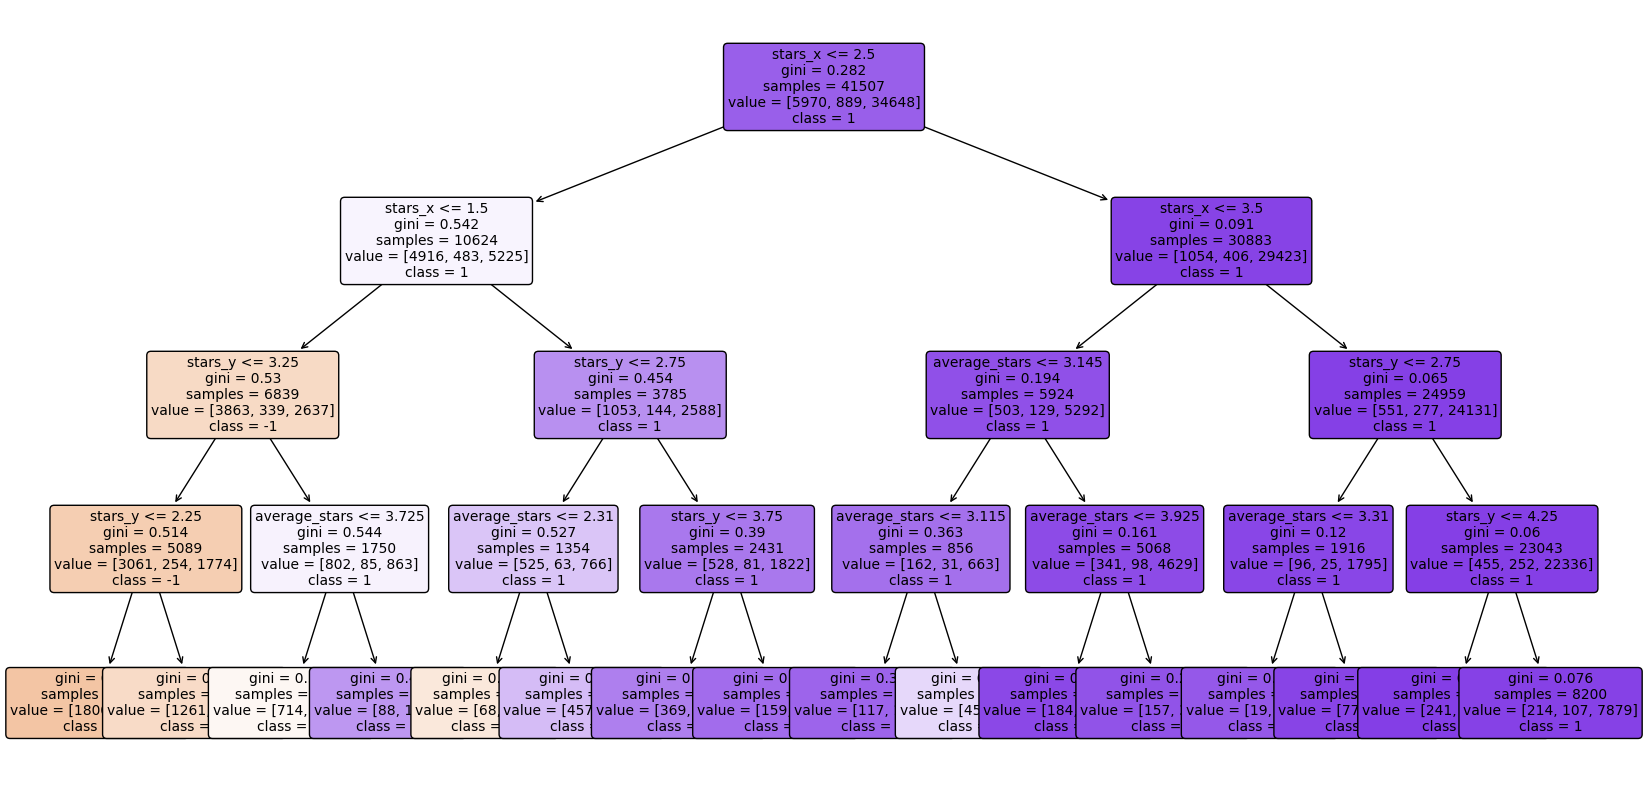

In [68]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    feature_names=X.columns,
    class_names=[str(c) for c in clf.classes_],
    filled=True,      # adds colors
    rounded=True,     # rounded boxes
    fontsize=10
)
plt.show()


Mejoro alrededor de 10% la precisión del modelo. Ahora pongamos sólo dos variables: 0 y 1 para observar su capaciadad de medición. 

In [69]:
# Unificamos las clases: todo lo que sea 0 pasa a -1
df_fast_food_prueba=df_fast_food
df_fast_food_prueba['sentimiento_bin'] = df_fast_food['sentimiento_num'].replace({0: -1})
df_fast_food_prueba.drop('sentimiento_num', axis=1, inplace=True)

In [70]:
# Separar los datos
X = df_fast_food_prueba.drop(columns=['sentimiento_bin'])
y = df_fast_food_prueba['sentimiento_bin']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
#Creamos arbol simplificando entre -1 y 1
clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # Puedes ajustar max_depth
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [72]:
#Validamos el modelo
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.863640743952973
              precision    recall  f1-score   support

          -1       0.60      0.56      0.58      1749
           1       0.91      0.92      0.92      8628

    accuracy                           0.86     10377
   macro avg       0.76      0.74      0.75     10377
weighted avg       0.86      0.86      0.86     10377



In [73]:
# Importancias de cada variable
importancias = clf.feature_importances_

# Crear un DataFrame ordenado

feature_importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print(feature_importancia)


            Variable  Importancia
0            stars_x   0.94503278
1            stars_y   0.03030514
5      average_stars   0.02466208
2    MedianHH_Income   0.00000000
3  Median_Home_Value   0.00000000
4    Median_RE_Taxes   0.00000000
6     top_influencer   0.00000000
7         intermedio   0.00000000
8   micro_influencer   0.00000000


Conclusion: El árbol mejororó su capacidad para explicar los sentimientos debido a que mejoró la presición y recall para predecir. No obstante, el modelo también descarta gran parte de las variables... solo se rectifica lo importante de tener una buena puntuacion en Yelp del restaurante. 

6. Creamos XGBoost

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)

In [77]:
# Convertir etiquetas de -1/1 a 0/1
y_train_bin = y_train.replace(-1, 0)
y_test_bin = y_test.replace(-1, 0)


In [80]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear y entrenar el modelo
xgb_clf = XGBClassifier(
    n_estimators=200,      # número de árboles (aumenta si es necesario)
    max_depth=4,           # profundidad máxima de cada árbol
    learning_rate=0.1,     # tasa de aprendizaje (más baja = más estable)
    subsample=0.8,          # fracción de muestras en cada árbol
    colsample_bytree=0.8,   # fracción de variables en cada árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train_bin)

# Predicciones
y_pred = xgb_clf.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7759468054350969
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1749
           0       0.00      0.00      0.00         0
           1       0.91      0.93      0.92      8628

    accuracy                           0.78     10377
   macro avg       0.30      0.31      0.31     10377
weighted avg       0.76      0.78      0.77     10377



c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\param\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie